In [17]:
import sys
import numpy as np
sys.path.append("../LWA_skymodels")
from Gasperin2020_source_models_to_skyh5 import convert_wsclean_txt_models_to_pyradiosky, format_ra_deg, format_dec_deg, interpolate_flux, fit_spectral_index
import matplotlib.pyplot as plt

In [8]:
source_file_dir = "/lustre/rbyrne/skymodels"
vir_cat_path = f"{source_file_dir}/Vir-sources.txt"
source_name = "Vir"

In [12]:
file = open(vir_cat_path, "r")
file_contents = file.readlines()
file.close()

header = file_contents[0]
data = file_contents[1:]
ncomps = len(data)

name = np.full(ncomps, "", dtype=object)
extended_model_group = np.full(ncomps, source_name, dtype=object)
ra_deg = np.full(ncomps, np.nan, dtype=float)
dec_deg = np.full(ncomps, np.nan, dtype=float)
flux_I_orig = np.full(ncomps, np.nan, dtype=float)
spectral_indices = np.zeros((ncomps, 6), dtype=float)
use_log_spectral_ind = np.zeros((ncomps), dtype=bool)
freq_hz = np.full(ncomps, np.nan, dtype=float)
major_axis_arcsec = np.zeros(ncomps, dtype=float)  # Not used by pyradiosky
minor_axis_arcsec = np.zeros(ncomps, dtype=float)  # Not used by pyradiosky
orientation = np.full(ncomps, np.nan, dtype=float)  # Not used by pyradiosky

for comp_ind in range(ncomps):
    line_split = data[comp_ind].strip("\n").split(",")

    # Deal with bracketed entries with more than one sub-entry
    line_split_new = []
    ind = 0
    while ind < len(line_split):
        if "[" in line_split[ind]:
            bracket_chunk = []
            while "]" not in line_split[ind]:
                bracket_chunk.append(line_split[ind].strip("[").strip("]"))
                ind += 1
            bracket_chunk.append(line_split[ind].strip("[").strip("]"))
            line_split_new.append(bracket_chunk)
            ind += 1
        else:
            line_split_new.append(line_split[ind])
            ind += 1

    name[comp_ind] = f"{source_name}_{line_split_new[0]}"
    ra_deg[comp_ind] = format_ra_deg(line_split_new[2])
    dec_deg[comp_ind] = format_dec_deg(line_split_new[3])
    flux_I_orig[comp_ind] = line_split_new[4]
    if isinstance(line_split_new[5], list):
        for ind, spec_ind_value in enumerate(line_split_new[5]):
            spectral_indices[comp_ind, ind] = spec_ind_value
    else:
        spectral_indices[comp_ind, 0] = line_split_new[5]
    if line_split_new[6] == "false":
        use_log_spectral_ind[comp_ind] = False
    elif line_split_new[6] == "true":
        use_log_spectral_ind[comp_ind] = True
    else:
        print("WARNING: Unknown spectral index type.")
    freq_hz[comp_ind] = line_split_new[7]
    if len(line_split_new[8]) > 0:
        major_axis_arcsec[comp_ind] = line_split_new[8]
    if len(line_split_new[9]) > 0:
        minor_axis_arcsec[comp_ind] = line_split_new[9]
    if len(line_split_new[10]) > 0:
        orientation[comp_ind] = line_split_new[10]

In [5]:
vir_cat = convert_wsclean_txt_models_to_pyradiosky(
    vir_cat_path,
    12e6,
    source_name="Vir",
)

array([0.39650117, 0.39650117, 0.39650117, ..., 0.39650117, 0.39650117,
       0.39650117])

In [21]:
print(spectral_indices)

[[-6.89202884e-03 -1.02472994e-02  1.12902073e-01  3.19574740e-01
   0.00000000e+00  0.00000000e+00]
 [ 4.35742175e-03  9.07475427e-02 -1.09302358e-01 -9.73321070e-01
   0.00000000e+00  0.00000000e+00]
 [-1.49372633e-02 -1.07819707e-01  2.74751836e-01  1.12505867e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.02343667e-01  3.02412180e-01  1.15876192e-01 -3.03029264e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.11385268e-01  3.87364556e+00 -6.60588655e+00 -3.43641435e+01
   0.00000000e+00  0.00000000e+00]
 [ 3.57048096e+00  4.26138437e+01 -6.76627831e+01 -4.50102053e+02
   0.00000000e+00  0.00000000e+00]]


In [26]:
interpolated_spectral_ind = []
interpolated_flux = []
frequencies_hz = np.arange(8e6, 200e6, 1e6)
for target_freq_hz in frequencies_hz:
    # Convert flux values to target freq
    flux_I = interpolate_flux(
        flux_I_orig, freq_hz, target_freq_hz, spectral_indices, use_log_spectral_ind
    )
    # Interpolate spectral indices to a single number. Use the same spectral index for all components.
    if np.min(use_log_spectral_ind):
        print(
            "ERROR: Not all spectral indices are use the ordinary polynomial convention. Exiting."
        )
        sys.exit(1)
    spectral_indices_use = fit_spectral_index(
        np.array([np.sum(flux_I)]),
        np.array([np.mean(freq_hz)]),
        target_freq_hz,
        np.sum(spectral_indices, axis=0)[np.newaxis, :],
        np.array([False]),
    )
    print(spectral_indices_use)
    interpolated_spectral_ind.append(spectral_indices_use[0])
    interpolated_flux.append(np.sum(flux_I))

[0.49368076]
[0.47419883]
[0.45105348]
[0.42497669]
[0.39650117]
[0.36602702]
[0.33386391]
[0.30025861]
[0.26541359]
[0.22949986]
[0.19266616]
[0.15504563]
[0.11676074]
[0.07792707]
[0.03865625]
[-0.00094178]
[-0.04075697]
[-0.08067763]
[-0.12058932]
[-0.16037392]
[-0.19990889]
[-0.23906673]
[-0.27771472]
[-0.31571469]
[-0.35292314]
[-0.38919144]
[-0.42436637]
[-0.45829081]
[-0.49080471]
[-0.5217464]
[-0.55095406]
[-0.57826766]
[-0.60353109]
[-0.62659464]
[-0.64731786]
[-0.66557261]
[-0.68124646]
[-0.69424633]
[-0.70450227]
[-0.71197137]
[-0.71664179]
[-0.71853665]
[-0.71771788]
[-0.71428979]
[-0.7084024]
[-0.70025427]
[-0.69009494]
[-0.67822679]
[-0.6650064]
[-0.65084529]
[-0.6362102]
[-0.62162293]
[-0.60765986]
[-0.59495135]
[-0.58418123]
[-0.57608663]
[-0.57145836]
[-0.57114246]
[-0.57604294]
[-0.58712649]
[-0.60542951]
[-0.63206807]
[-0.66825164]
[-0.71530142]
[-0.77467446]
[-0.84799502]
[-0.93709526]
[-1.0440679]
[-1.17133456]
[-1.32173506]
[-1.49864508]
[-1.70613284]
[-1.94917065

Text(0, 0.5, 'Interpolated Spectral Index, Log Convention')

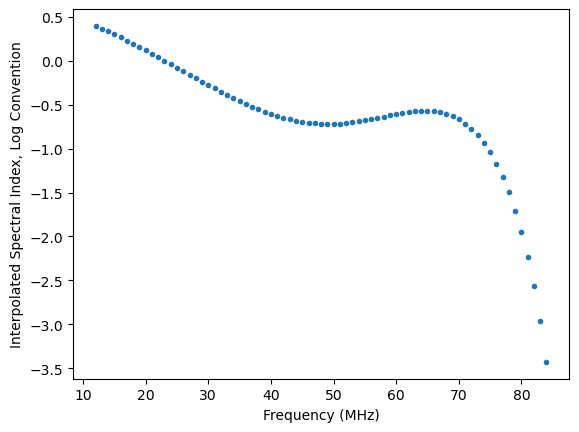

In [20]:
plt.plot(frequencies_hz/1e6, interpolated_spectral_ind, ".")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Interpolated Spectral Index, Log Convention")

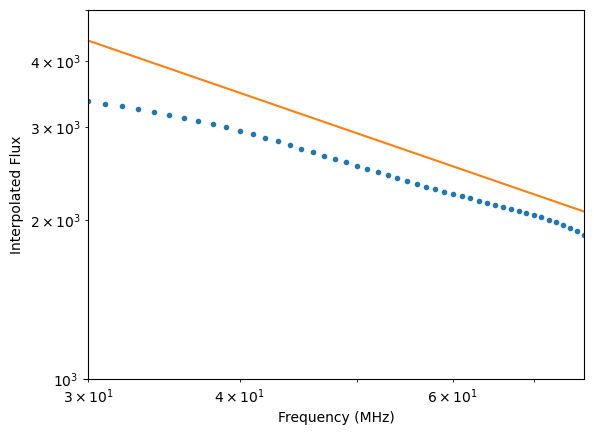

In [37]:
plt.plot(frequencies_hz/1e6, interpolated_flux, ".")
plt.plot(frequencies_hz/1e6, np.exp(np.log(1226) - 0.79 * np.log(frequencies_hz/150e6)))
plt.xlabel("Frequency (MHz)")
plt.ylabel("Interpolated Flux")
plt.yscale("log")
plt.xscale("log")
plt.xlim([30,77])
plt.ylim([1e3, 5e3])
plt.show()